In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import json

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix

In [373]:
train = np.load('D:/meme_data/features/train.npz')

txt_fea_train = train['txt_fea']
img_fea_train = train['img_fea']
label_train = train['label']


dev = np.load('D:/meme_data/features/dev.npz')
txt_fea_dev = dev['txt_fea']
img_fea_dev = dev['img_fea']
label_dev = dev['label']

num_classes = len(np.unique(label_train))


X1 = (img_fea_train - img_fea_train.mean()) / img_fea_train.std()
X2 = (txt_fea_train - txt_fea_train.mean()) / txt_fea_train.std()
X = np.concatenate((X1, X2), axis=1)

X1 = (img_fea_dev - img_fea_train.mean()) / img_fea_train.std()
X2 = (txt_fea_dev - txt_fea_train.mean()) / txt_fea_train.std()
X_dev = np.concatenate((X1, X2), axis=1)

N_feature = X.shape[1]

In [393]:
N_feature = X.shape[1]

model = Sequential([
    layers.Dropout(0.5, input_shape = (N_feature, )),
    layers.Dense(32, activation= 'sigmoid'),
    layers.Dropout(0.3),
    layers.Dense(1, activation= 'sigmoid')
])

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_173 (Dropout)        (None, 1792)              0         
_________________________________________________________________
dense_197 (Dense)            (None, 32)                57376     
_________________________________________________________________
dropout_174 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 1)                 33        
Total params: 57,409
Trainable params: 57,409
Non-trainable params: 0
_________________________________________________________________


In [394]:
wei = np.where(label_train==1,
               len(label_train[label_train==0])/ len(label_train[label_train==1]), 1)

epochs = 30
history = model.fit(
    X, label_train,
    validation_data = (X_dev, label_dev),
    sample_weight=wei,
    epochs=epochs
)

  ...
    to  
  ['...']
Train on 8500 samples, validate on 500 samples
Epoch 1/30
8500/8500 [==============================] - 3s 346us/sample - loss: 0.8505 - accuracy: 0.6064 - auc_47: 0.6480 - val_loss: 0.6867 - val_accuracy: 0.5760 - val_auc_47: 0.5930
Epoch 2/30
8500/8500 [==============================] - 1s 130us/sample - loss: 0.7949 - accuracy: 0.6548 - auc_47: 0.7142 - val_loss: 0.6843 - val_accuracy: 0.5800 - val_auc_47: 0.6143
Epoch 3/30
8500/8500 [==============================] - 1s 129us/sample - loss: 0.7812 - accuracy: 0.6685 - auc_47: 0.7298 - val_loss: 0.6768 - val_accuracy: 0.5860 - val_auc_47: 0.6296
Epoch 4/30
8500/8500 [==============================] - 1s 128us/sample - loss: 0.7656 - accuracy: 0.6808 - auc_47: 0.7436 - val_loss: 0.6679 - val_accuracy: 0.6100 - val_auc_47: 0.6418
Epoch 5/30
8500/8500 [==============================] - 1s 135us/sample - loss: 0.7551 - accuracy: 0.6839 - auc_47: 0.7521 - val_loss: 0.6680 - val_accuracy: 0.6000 - val_auc_47: 0.642

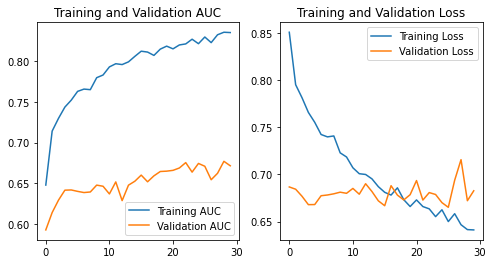

In [395]:
acc = history.history[list(history.history.keys())[2]]
val_acc = history.history[list(history.history.keys())[-1]]

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training AUC')
plt.plot(epochs_range, val_acc, label='Validation AUC')
plt.legend(loc='lower right')
plt.title('Training and Validation AUC')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation AUC ROC with image: 0.6713760000000001


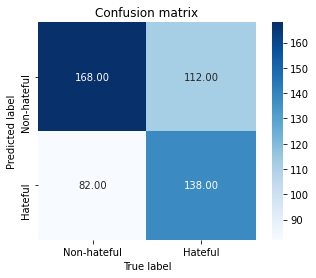

In [396]:
prob = model.predict(X_dev)
print('Validation AUC ROC with image:', roc_auc_score(label_dev, prob, multi_class='ovo'))

confusion = confusion_matrix(
label_dev, np.round(prob, 0))

axis_labels = ['Non-hateful', 'Hateful']
ax = sns.heatmap(
    confusion.T, xticklabels=axis_labels, yticklabels=axis_labels,
    cmap='Blues', annot=True, fmt='.2f', square=True)
plt.title("Confusion matrix")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()